In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv("creditcard.csv")
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
# Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [4]:
# Feature Extraction starts here:

# 1. Extract transaction hour from 'Time' (Time in seconds from first transaction)
df['Transaction_hour'] = ((df['Time'] // 3600) % 24).astype(int)  # hour of day 0-23

In [5]:
# One-hot encode 'Transaction_hour' for model (optional, here just adding numeric)
# or you could use cyclic features:
df['Hour_sin'] = np.sin(2 * np.pi * df['Transaction_hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Transaction_hour'] / 24)

In [6]:
# 2. Interaction features between scaled_amount and V1, V2
df['Amount_V1_interaction'] = df['scaled_amount'] * df['V1']
df['Amount_V2_interaction'] = df['scaled_amount'] * df['V2']

In [7]:
# 3. Absolute value of some PCA features (capture magnitude)
df['Abs_V3'] = df['V3'].abs()
df['Abs_V4'] = df['V4'].abs()

In [8]:
# 4. Log transform of amount (add small constant to avoid log(0))
df['Log_Amount'] = np.log1p(df['Amount'])

In [9]:
# Drop original 'Amount' and 'Time' columns
df.drop(['Amount', 'Time', 'Transaction_hour'], axis=1, inplace=True)

In [10]:
# Rearranging columns: put scaled_time, scaled_amount, new features, original PCA, Class
new_features = ['Hour_sin', 'Hour_cos', 'Amount_V1_interaction', 'Amount_V2_interaction', 'Abs_V3', 'Abs_V4', 'Log_Amount']
cols = ['scaled_time', 'scaled_amount'] + new_features + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount', 'Class'] + new_features] + ['Class']
scaled_data = df[cols]

In [11]:
X = scaled_data.drop('Class', axis=1)
y = scaled_data['Class']

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [14]:
# LightGBM
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_smote, y_train_smote)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [15]:
# MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)
mlp_model.fit(X_train_smote, y_train_smote)
y_pred_mlp = mlp_model.predict(X_test)

📊 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



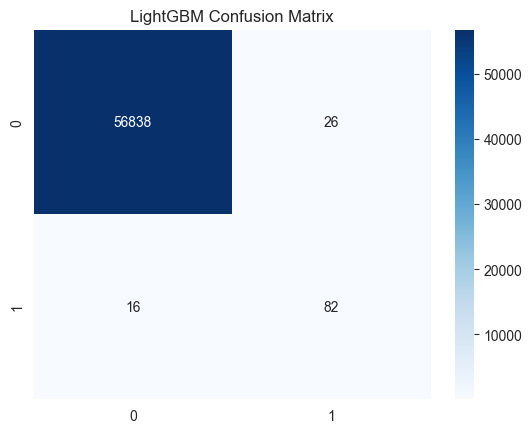

In [16]:
# LightGBM Evaluation
print("📊 LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.show()


📊 MLP Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



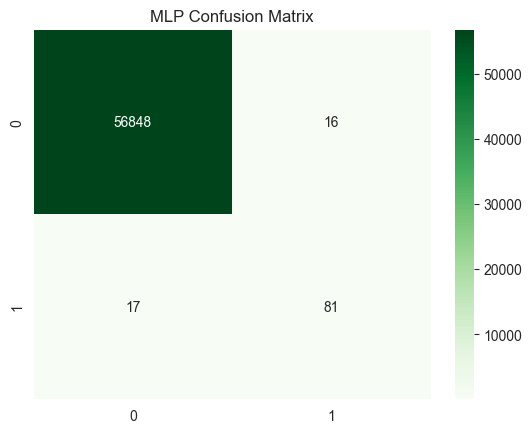

In [17]:
# MLP Evaluation
print("📊 MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens')
plt.title("MLP Confusion Matrix")
plt.show()